## Changing viscosity configuration

Using the same external forcing as in CNTDIFF/run03, I modified the viscositi configuration in 5 runs (CNTDIFF/ run31-35). Here's a summary of those runs (all with 1 tracer, kv=10^-5 m^2/s)

|run|viscAh, viscAv|ViscSmag| viscAhRemax|viscAhGridMin|Unstable?|
|:--:|:-----------:|:------:|:---------:|:------------:|:------:|
| 03 |    1e-2     |  2.2   |  10       |   0.01       |No      |
| 31 |    1e-5     |  2.2   |  10       |   0.01       |No      |
| 32 |    1e-2     |   -     |    -       |      -        |No      |
| 33 |    1e-5     |     -   |    -       |      -        |Yes     |
| 34 |       -      |  2.2   |    -       |      -        |No      |
| 35 |       -      |     -   |  10       |       -       |Yes     |

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import canyon_tools.readout_tools as rdout

import canyon_tools.metrics_tools as mpt


In [298]:
# load grid variables
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
GridOut = Dataset(Grid)
GridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
GridNoCOut = Dataset(GridNoC)
State03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
State31 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run31/stateGlob.nc'
State32 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run32/stateGlob.nc'
State34 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run34/stateGlob.nc'


nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rdout.getField(Grid, 'XC') # x coords tracer cells
yc = rdout.getField(Grid, 'YC') # y coords tracer cells
rc = GridOut.variables['RC']
z = StateOut.variables['Z']
times = StateOut.variables['T']

bathy = rdout.getField(Grid, 'Depth')

hFacC = rdout.getField(Grid, 'HFacC')
MaskC = rdout.getMask(Grid, 'HFacC')

rA = rdout.getField(GridNoC, 'rA') 
drF = GridNoCOut.variables['drF'] # vertical distance between faces
drC = GridNoCOut.variables['drC'] # vertical distance between centers
dxf = GridNoCOut.variables['dxF']

hFacCNoC = rdout.getField(GridNoC, 'HFacC')
mask_NoC = rdout.getMask(GridNoC, 'HFacC')


### Along shore velocity

In [97]:
# get u and v components of velocity
Ustag = rdout.getField(State03,'U')
Vstag = rdout.getField(State03,'V')
UU03, VV03 = rdout.unstagger(Ustag,Vstag)

Ustag = rdout.getField(State31,'U')
Vstag = rdout.getField(State31,'V')
UU31, VV31 = rdout.unstagger(Ustag,Vstag)

Ustag = rdout.getField(State32,'U')
Vstag = rdout.getField(State32,'V')
UU32, VV32 = rdout.unstagger(Ustag,Vstag)

Ustag = rdout.getField(State34,'U')
Vstag = rdout.getField(State34,'V')
UU34, VV34 = rdout.unstagger(Ustag,Vstag)

In [143]:
def plotU_timeseries(UU,times,kk,ii):
    '''
    '''
    sns.set_context('talk')
    sns.set_style('white')

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

    ax1.plot(times[:]/86400.0,UU[:,kk,10,ii], 'r', label = ('CS pos = %1.1f km' %(yc[10,ii]/1000.0)))
    ax1.plot(times[:]/86400.0,UU[:,kk,180,ii], 'b', label = ('CS pos = %1.1f km' %(yc[180,ii]/1000.0)))
    ax1.plot(times[:]/86400.0,UU[:,kk,227,ii], 'purple', label = ('CS pos = %1.1f km' %(yc[227,ii]/1000.0)))
    ax1.plot(times[:]/86400.0,UU[:,kk,267,ii], 'orange', label = ('CS pos = %1.1f km' %(yc[267,ii]/1000.0)))
    ax1.plot(times[:]/86400.0,UU[:,kk,350,ii], 'g', label = ('CS pos = %1.1f km' %(yc[350,ii]/1000.0)))

    ax1.legend(loc = 0)
    ax1.set_ylabel('Alongshore velocity (m/s)')
    ax1.set_xlabel('time (days)')
    ax1.set_title('at z = %1.1f m' %z[kk])

    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,750,900,1050], colors = '0.4')
    ax2.clabel(cntr)
    ax2.plot(xc[10,ii]/1000.0,yc[10,ii]/1000.0,'ro',markersize = 14)
    ax2.plot(xc[180,ii]/1000.0,yc[180,ii]/1000.0,'bo',markersize = 14)
    ax2.plot(xc[227,ii]/1000.0,yc[227,ii]/1000.0,'o',color = 'purple',markersize = 14)
    ax2.plot(xc[267,ii]/1000.0,yc[267,ii]/1000.0,'o',color='orange',markersize = 14)
    ax2.plot(xc[350,ii]/1000.0,yc[350,ii]/1000.0,'go',markersize = 14)
    ax2.set_xlabel('(km)')
    ax2.set_ylabel('(km)')

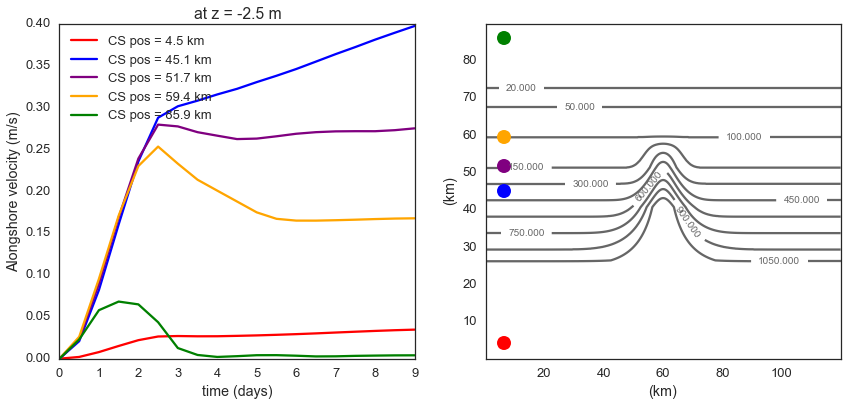

In [144]:
plotU_timeseries(UU03-UU31,times,0,10)


In [ ]:
plotU_timeseries(UU03-UU32,times,0,10)


In [ ]:
plotU_timeseries(UU03-UU34,times,0,10)


## SSH anomaly

Kämpf(2006) forced his runs with ssh. He shows a plot whre there is a clear relationship between upwelling index (wind) and ssh. The way it works is that SSH at the coast is ramped linearly for 2 days and kept constant during 3 days, while ssh at the open ocean boundary is kept at its original value. He changes the forcing by using different values of SSH at the coast.

A SSH anomaly of -10 cm (a drop, equivalent to an upwelling index of 1) generates, in his model, a coastal upwelling jet 0f approx 30 cm/s. 

By the way, all of this is in the Southern Hemisphere.

What is my ssh anomaly?

Kämpf, J. (2006) Transient wind-driven upwelling in a submarine canyon: A process-oriented modeling study, J. Geophys. Res., 111, C11011. 

In [159]:
# Load ssh field
Eta = rdout.getField(State,'Eta')

In [226]:
def contourfEta(Eta,tt1,tt2,tt3,tt4,tt5,tt6,tt7,tt8,tt9):
    '''
    '''
    sns.set_context('talk')
    sns.set_style('white')

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,10), sharex=True, sharey=True)

    cf = ax1.contourf(xc/1000.0,yc/1000.0,Eta[tt1,:,:], 20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax1.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax1.clabel(cntr)
    
    cf = ax2.contourf(xc/1000.0,yc/1000.0,Eta[tt2,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax2.clabel(cntr)
    
    cf = ax3.contourf(xc/1000.0,yc/1000.0,Eta[tt3,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax3.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax3.clabel(cntr)
    
    cf = ax4.contourf(xc/1000.0,yc/1000.0,Eta[tt4,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax4.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax4.clabel(cntr)
    
    cf = ax5.contourf(xc/1000.0,yc/1000.0,Eta[tt5,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax5.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax5.clabel(cntr)
    
    cf = ax6.contourf(xc/1000.0,yc/1000.0,Eta[tt6,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax6.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax6.clabel(cntr)
    
    cf = ax7.contourf(xc/1000.0,yc/1000.0,Eta[tt7,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax7.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax7.clabel(cntr)
    
    cf = ax8.contourf(xc/1000.0,yc/1000.0,Eta[tt8,:,:], 20,cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax8.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax8.clabel(cntr)
    
    cf9 = ax9.contourf(xc/1000.0,yc/1000.0,Eta[tt9,:,:],20, cmap = 'PiYG', vmax = 0.1, vmin= -0.1)
    cntr = ax9.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax9.clabel(cntr)
    
    ax1.annotate('Day 1', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    ax9.annotate('Day 9', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    
    cbar_ax = fig.add_axes([0.12, -0.02, 0.8, 0.03])
    fig.colorbar(cf9, cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_xlabel('$\eta$ (m)')
    
    ax4.set_ylabel('(km)')
    ax8.set_xlabel('(km)')
    plt.tight_layout()
    

In [239]:
def plotEta(EtaSlice, times, title):
    '''
    '''
    sns.set_context('talk')
    sns.set_style('dark')
    sns.set_palette(sns.dark_palette("green",10))
    
    fig,(ax1) = plt.subplots(1,1,figsize=(8,8), sharex=True, sharey=True)
    
    for tt in times:
        ax1.plot(yc[:,1],EtaSlice[tt,:],label = 'day %1.1f' %(tt/2))
    
    ax1.set_ylabel('$\eta$ (m)')
    ax1.set_xlabel('Cross-shore distance (km)')
    ax1.set_title(title)
    ax1.legend(loc=0)
    plt.tight_layout()
    

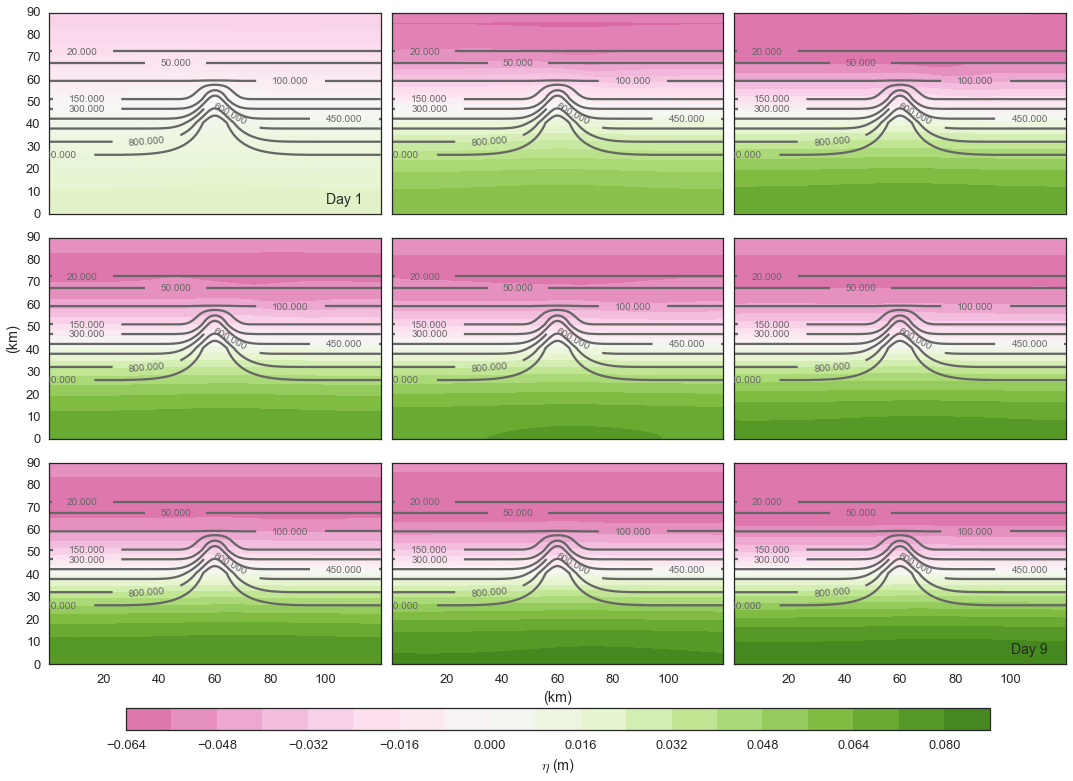

In [233]:
contourfEta(Eta,2,4,6,8,10,12,14,16,18)

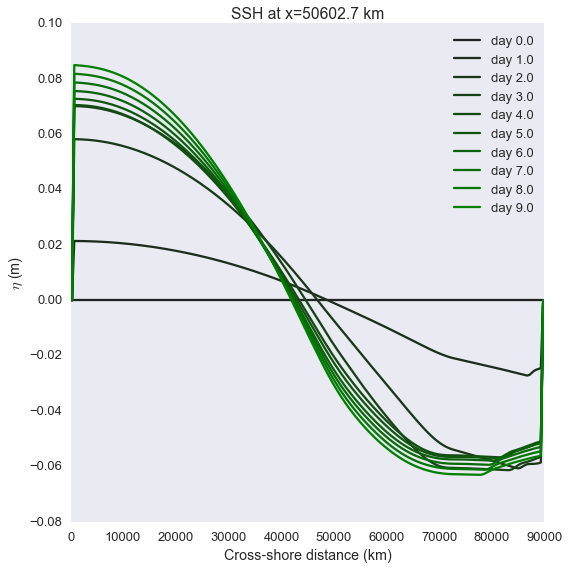

In [241]:
plotEta(Eta[:,:,120], [0,2,4,6,8,10,12,14,16,18], 'SSH at x=%1.1f km' %xc[1,120])

SSH keeps getting deeper at the coast and higher at the open ocean as the simulation evolves. What is that zero at the boundaries?

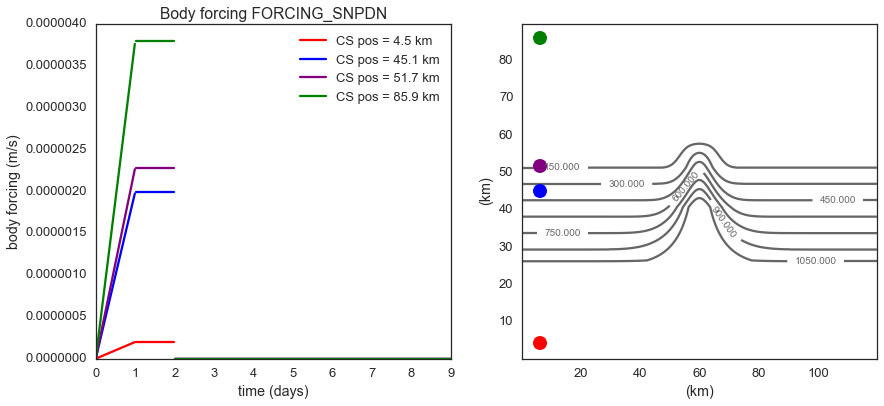

SSH increases until day 2 at open ocean bdy and decreases over coast. Then , slow return to flat top.

## Quick comparison of temperatures

In [267]:
Temp = rdout.getField(State,'Temp')
Tempspn = rdout.getField(StateSPNDN,'Temp')



In [272]:
MaskExp = np.expand_dims(MaskC,0)
MaskT = MaskExp + np.zeros(Temp.shape)

Temp_masked = np.ma.masked_array(Temp,mask = MaskT) 
Tempspn_masked = np.ma.masked_array(Tempspn,mask = MaskT) 

In [287]:
def contourfTemp(Temp,tt1=2,tt2=4,tt3=6,tt4=8,tt5=10,tt6=12,tt7=14,tt8=16,tt9=18,tmax=17,tmin=0,colormap='rainbow'):
    '''
    '''
    sns.set_context('talk')
    sns.set_style('white')

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,10), sharex=True, sharey=True)

    cf = ax1.contourf(xc/1000.0,yc/1000.0,Temp[tt1,:,:], 20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax1.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax1.clabel(cntr)
    
    cf = ax2.contourf(xc/1000.0,yc/1000.0,Temp[tt2,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax2.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax2.clabel(cntr)
    
    cf = ax3.contourf(xc/1000.0,yc/1000.0,Temp[tt3,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax3.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax3.clabel(cntr)
    
    cf = ax4.contourf(xc/1000.0,yc/1000.0,Temp[tt4,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax4.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax4.clabel(cntr)
    
    cf = ax5.contourf(xc/1000.0,yc/1000.0,Temp[tt5,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax5.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax5.clabel(cntr)
    
    cf = ax6.contourf(xc/1000.0,yc/1000.0,Temp[tt6,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax6.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax6.clabel(cntr)
    
    cf = ax7.contourf(xc/1000.0,yc/1000.0,Temp[tt7,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax7.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax7.clabel(cntr)
    
    cf = ax8.contourf(xc/1000.0,yc/1000.0,Temp[tt8,:,:], 20,cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax8.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax8.clabel(cntr)
    
    cf9 = ax9.contourf(xc/1000.0,yc/1000.0,Temp[tt9,:,:],20, cmap = colormap, vmax = tmax, vmin=tmin)
    cntr = ax9.contour(xc/1000.0,yc/1000.0,bathy,[20,50,100,150,300,450,600,800,1000], colors = '0.4')
    ax9.clabel(cntr)
    
    ax1.annotate('Day 1', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    ax9.annotate('Day 9', xy=(1, 1), xytext=(100, 5), fontsize = 14)
    
    cbar_ax = fig.add_axes([0.12, -0.02, 0.8, 0.03])
    fig.colorbar(cf9, cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_xlabel('Temperature ($^{\circ}C$)')
    
    ax4.set_ylabel('(km)')
    ax8.set_xlabel('(km)')
    plt.tight_layout()

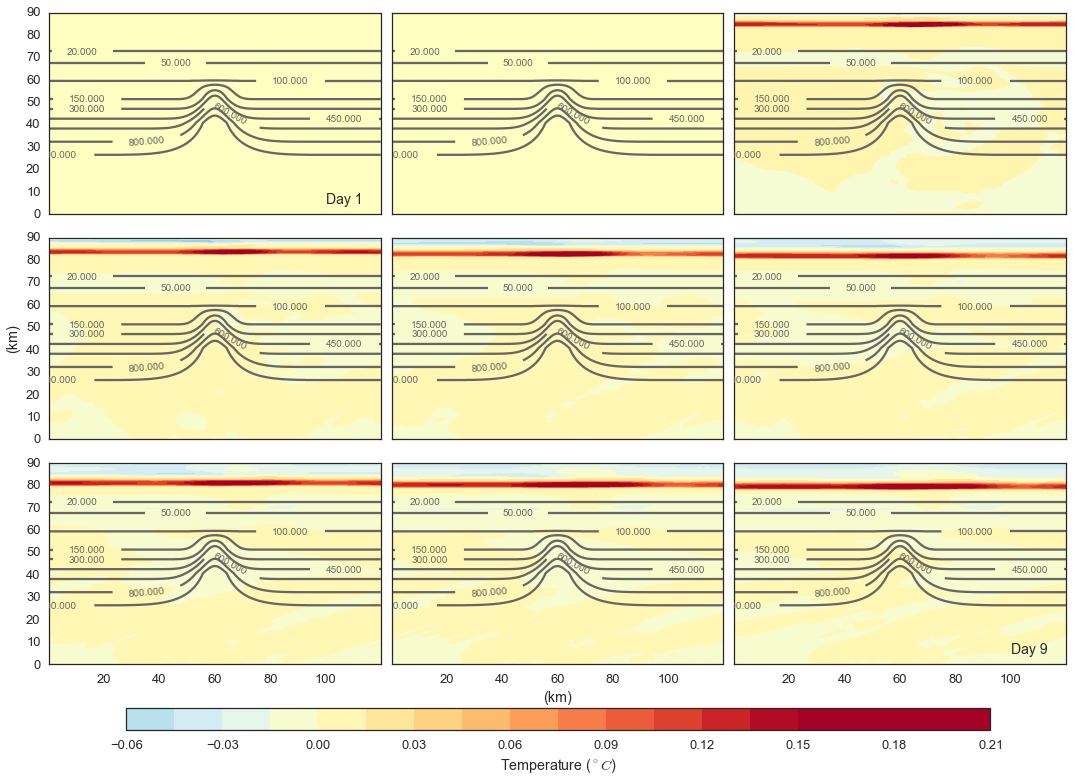

In [294]:
contourfTemp(Temp_masked[:,0,:,:]-Tempspn_masked[:,0,:,:],tmax=0.15,tmin=-0.15,colormap='RdYlBu_r')

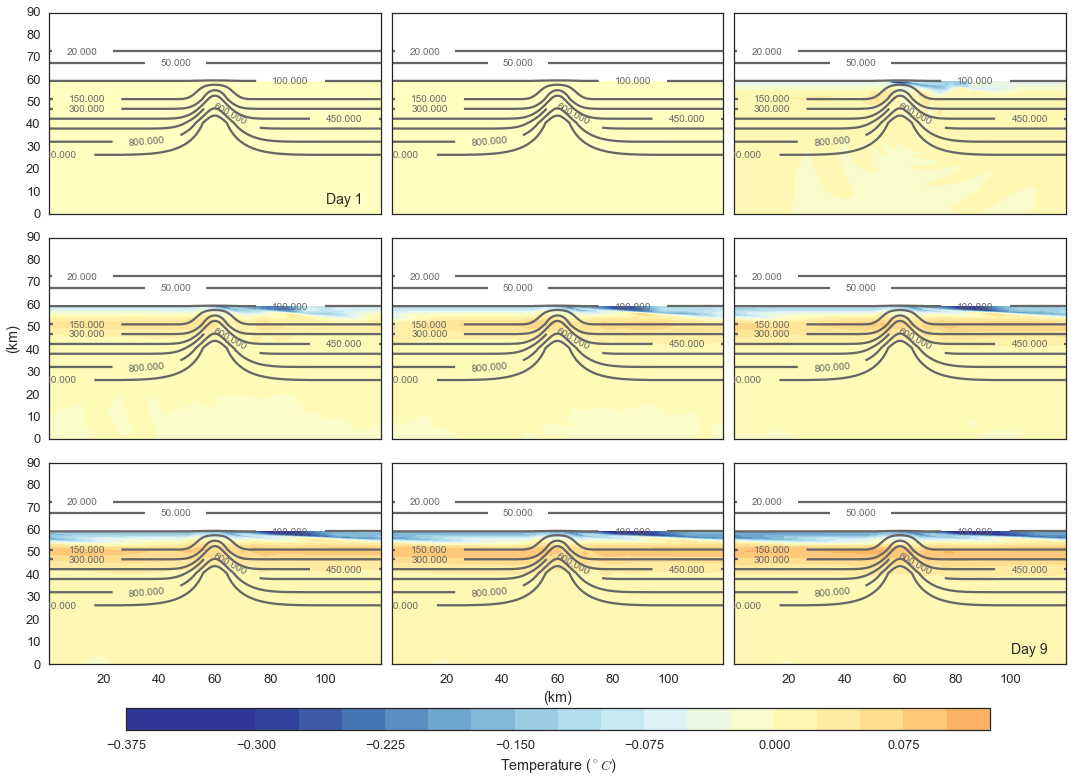

In [291]:
contourfTemp(Temp_masked[:,20,:,:]-Tempspn_masked[:,20,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

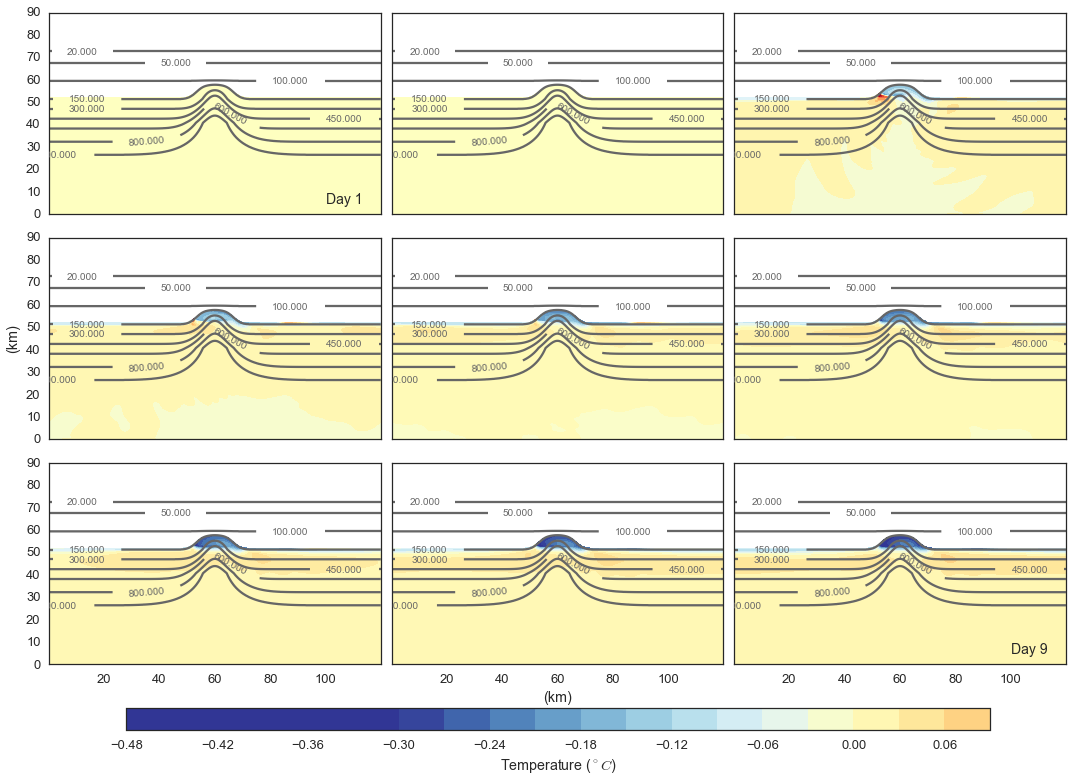

In [295]:
contourfTemp(Temp_masked[:,29,:,:]-Tempspn_masked[:,29,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

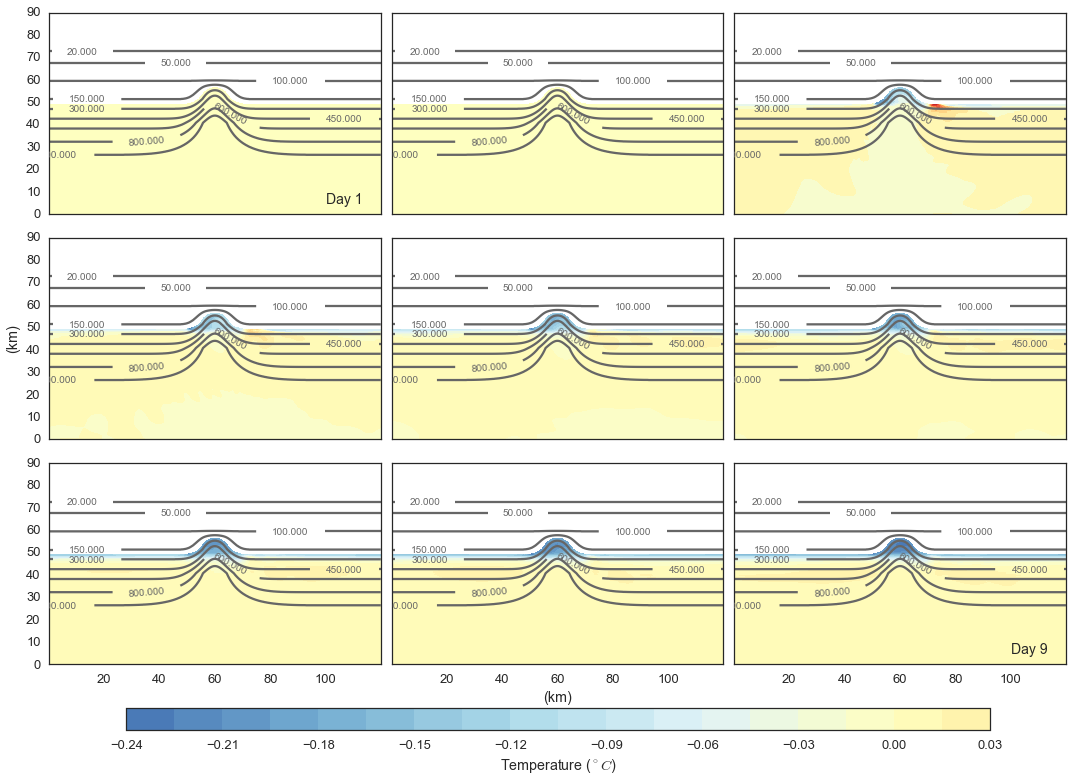

In [296]:
contourfTemp(Temp_masked[:,40,:,:]-Tempspn_masked[:,40,:,:],tmax=0.3,tmin=-0.3,colormap='RdYlBu_r')

## Upwelling differences - vertically integrated tracer along shelf

In [301]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [299]:
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
Tr1 = rdout.getField(Ptracers,'Tr1')

PtracersSpn = '/ocean/kramosmu/MITgcm/TracerExperiments/FORCING_SPNDN/run01/ptracersGlob.nc'
Tr1spn = rdout.getField(PtracersSpn,'Tr1')


In [304]:
HCW,TrMASS = HCW_Tracer_AlongShelf(Tr1,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)
HCWspn,TrMASSspn = HCW_Tracer_AlongShelf(Tr1spn,mask_NoC,30,rA,hFacCNoC,drF,227,30,180,50)

('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


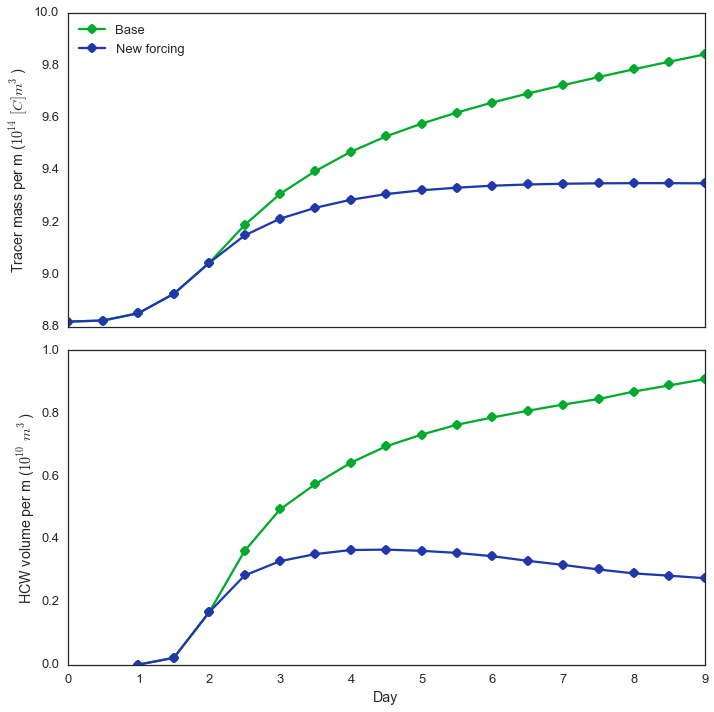

In [306]:
sns.set_context('talk')
sns.set_style('white')

fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMASS,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base')
ax1.plot(tt/2.,np.sum(TrMASSspn,axis=1)/1.E14,sns.xkcd_rgb["sapphire"],marker = 'o',label='New forcing')
   
ax2.plot(tt/2.,np.sum(HCW,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base')
ax2.plot(tt/2.,np.sum(HCWspn,axis=1)/1.E10,sns.xkcd_rgb["sapphire"],marker = 'o',label='New forcing')
 
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
plt.tight_layout()

plt.show()

In [309]:
u_approx=(0.12*9.81)/(90000*9.66E-4)
print(u_approx)

0.0135403726708
